In [38]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
from keras.layers.core import Activation
from keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from keras.optimizers import RMSprop
from keras.utils import np_utils
from tensorflow.compat.v1.keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose
from keras.callbacks import ReduceLROnPlateau

In [63]:
#f_data =  '/gs/home/wenjiao/zrx-2DGP/2DCNN-sin/pydata/trainsingle'
f_data = '.\trainsin'
stacks = os.listdir(f_data)
numS = int(len(stacks))

nTG = 90 # Number of time-points
xX = 100
tpsfD = np.ndarray(
        (numS, int(nTG), int(xX),  int(1)), dtype=np.float32  
        )
t1 = np.ndarray(
        (numS, int(xX), int(1)), dtype=np.float32
        )
i = 0;
for d in stacks:
    # Save values to respective mapping
    f = h5py.File(os.path.join(f_data,d),'r') 
    tpsfD[i,:,:,0] = f.get('sigD_a')
    f = h5py.File(os.path.join(f_data,d),'r') 
    t1[i,:] = f.get('t1_a')
    i = i + 1
    
tpsfD[np.isnan(tpsfD)]=0
    
tpsfD =  np.moveaxis(tpsfD, 1, -2)

def norm(data):
    _range = np.max(data) - np.min(data)
    return data / _range
t1=norm(t1)
print(t1)

[[[0.11482575]
  [0.89438283]
  [1.0404357 ]
  ...
  [0.2057458 ]
  [0.14423156]
  [1.0757622 ]]

 [[0.9017317 ]
  [0.16931212]
  [0.92924285]
  ...
  [0.9115608 ]
  [0.18192984]
  [0.17215416]]

 [[1.043794  ]
  [0.14339657]
  [0.9749211 ]
  ...
  [0.15237416]
  [1.0376008 ]
  [1.019669  ]]

 ...

 [[0.88890064]
  [0.19930372]
  [1.0388055 ]
  ...
  [0.1750693 ]
  [1.0702246 ]
  [0.931305  ]]

 [[0.21018508]
  [1.0240307 ]
  [0.16440907]
  ...
  [0.13124827]
  [0.17233028]
  [0.16692233]]

 [[1.0052361 ]
  [0.90126127]
  [0.9253435 ]
  ...
  [1.0789585 ]
  [0.90918005]
  [0.97234493]]]


In [64]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
tpsfD.shape

(600, 100, 90, 1)

In [65]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [66]:
modelD = None
xX = 100;


t_data = Input(shape=(xX,90,1))
tpsf = t_data

# # # # # # # # 2D-Model # # # # # # # #

tpsf = Conv2D(10,kernel_size=(1,10),strides=(1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)


tpsf = Conv2D(128,1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(128,1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(128, 1,tpsf)
tpsf = resblock_2D_BN(128, 1,tpsf)
tpsf = Reshape((xX,2304))(tpsf)

# Short-lifetime branch
imgT1 = Dense(64, activation=None)(tpsf)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Dense(32, activation=None)(imgT1)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Dense(1, activation=None)(imgT1)
imgT1 = Activation('relu')(imgT1)

# Long-lifetime branch
imgT2 = Dense(64, activation=None)(tpsf)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Dense(32, activation=None)(imgT2)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Dense(1, activation=None)(imgT2)
imgT2 = Activation('relu')(imgT2)

# Amplitude-Ratio branch
imgTR = Dense(64, activation=None)(tpsf)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Dense(32, activation=None)(imgTR)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Dense(1, activation=None)(imgTR) 
imgTR = Activation('relu')(imgTR)


modelD = Model(inputs=[t_data], outputs=[imgT1])
rmsprop = RMSprop(lr=1e-5)

modelD.compile(loss='mse',
              optimizer= 'adam',
              metrics=['mae'])

In [67]:
# Setting patience (patience = 15 recommended)
#tpsfD=tpsfD.reshape
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 15, 
                              verbose = 0,
                              mode = 'auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')

fN = 'testName' # Assign some name for weights and training/validation loss curves here

# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
history = History()
csv_logger = CSVLogger(fN+'.log')
history = modelD.fit([tpsfD],[t1],
          validation_split=0.2,
          batch_size=20, epochs=500,verbose=1, shuffle=True, callbacks=[earlyStopping,csv_logger,modelCheckPoint,reduce_lr])

Epoch 1/500
24/24 [==============================] - 18s 693ms/step - loss: 0.1714 - mae: 0.2790 - val_loss: 0.4603 - val_mae: 0.5314
Epoch 2/500
24/24 [==============================] - 17s 726ms/step - loss: 0.0157 - mae: 0.1083 - val_loss: 0.4249 - val_mae: 0.4949
Epoch 3/500
24/24 [==============================] - 19s 807ms/step - loss: 0.0134 - mae: 0.0981 - val_loss: 0.3822 - val_mae: 0.4550
Epoch 4/500
24/24 [==============================] - 19s 809ms/step - loss: 0.0103 - mae: 0.0838 - val_loss: 0.3588 - val_mae: 0.4376
Epoch 5/500
24/24 [==============================] - 18s 770ms/step - loss: 0.0088 - mae: 0.0754 - val_loss: 0.3179 - val_mae: 0.4141
Epoch 6/500
24/24 [==============================] - 18s 774ms/step - loss: 0.0084 - mae: 0.0725 - val_loss: 0.2785 - val_mae: 0.4064
Epoch 7/500
24/24 [==============================] - 18s 766ms/step - loss: 0.0079 - mae: 0.0691 - val_loss: 0.2398 - val_mae: 0.4123
Epoch 8/500
24/24 [==============================] - 18s 758ms

In [75]:
t_data = '.\testbi'
#t_data = '/gs/home/wenjiao/zrx-2DGP/Group-bi/pydata/fitbi' # directory with test data
stacksT = os.listdir(t_data)
numT = int(len(stacksT))

nTG = 90
xX = 58


tpsfT = np.ndarray(
        (numT, int(nTG), int(xX),  int(1)), dtype=np.float32
        )
t1T = np.ndarray(
        (numT, int(xX), int(1)), dtype=np.float32
        )

def norm(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
i = 0;

for d in stacksT:
    #Save values to respective mapping
    f = h5py.File(os.path.join(t_data,d),'r') 
    tpsfT[i,:,:,0] = f.get('sigD_sin')
    f = h5py.File(os.path.join(t_data,d),'r') 
    t1T[i,:] = f.get('t_sin')
#tpsfT =  np.moveaxis(tpsfT,1,-2)
tpsfT = np.moveaxis(tpsfT, 1, 2)
tpsfT.shape
tpsfT=tpsfT.reshape(58,90)
b=np.zeros((42,90))
pre=np.append(b,tpsfT)
pre.shape
pre=pre.reshape(1,100,90,1)
pre.shape

print(pre)


[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.89492285]
   [0.9109897 ]
   [0.93316197]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.88404393]
   [0.89082688]
   [0.91602069]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.87657511]
   [0.876252  ]
   [0.88400644]]]]


In [76]:
# Perform inference on test data with trained model
testV = modelD.predict(pre)
import pickle

def save_variable(v,filename):
        f = open(filename,'wb')
        pickle.dump(v,f)
        f.close()
        return filename

def load_variable(filename):
        f=open(filename,'rb')
        r=pickle.load(f)
        f.close()
        return r

import joblib
joblib.dump(testV,'smilesin2080N.pkl')
modelD.save('smilesin2080N.h5')


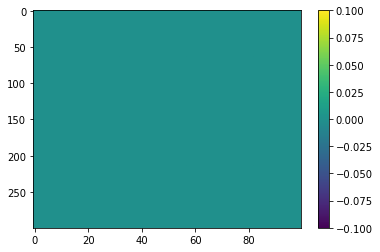